In [1]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.core.cell_types_cache import ReporterStatus as RS
from allensdk.ephys.feature_extractor import EphysFeatureExtractor
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

ctc = CellTypesCache()
cells = ctc.get_cells()
cell_index = {c['id']: c for c in cells}

ephys_features = ctc.get_ephys_features()

###Create dataframe to work with. Add cell metadata so we can start filtering

#####It might be easier to save the dataframes to .csv and reload them so future users don't have to recreate dataframes if they want to play with the data

In [3]:
features_df = pd.DataFrame(data=ephys_features)
features_df['cre_line'], features_df['cre_reporter'],features_df['location'] = None, None, None
features_df['dendrite_type'],features_df['depth'] = None, None
for i, spec_id in enumerate(features_df['specimen_id']):
    features_df['cre_line'][i] = cell_index[spec_id]['transgenic_line']
    features_df['cre_reporter'][i] = cell_index[spec_id]['cell_reporter']['name']
    layer = cell_index[spec_id]['structure']['acronym']
    if '5' in layer:
        features_df['location'][i] = 'layer 5'
    else:
        features_df['location'][i] = 'other'
    features_df['dendrite_type'][i] = cell_index[spec_id]['dendrite_type']
    features_df['depth'][i] = cell_index[spec_id]['cell_soma_locations'][0]['normalized_depth']


In [3]:
l5_df = features_df[(features_df['location']=='layer 5') & (features_df['dendrite_type'] == 'spiny')]
l5_df.head()

,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest,cre_line,cre_reporter,location,dendrite_type,depth
3,0.113440,86.34900,-9.024376,0.204990,0.143820,4.080805,0.004870,-43.968754,-46.072919,-46.835941,...,3.617618,3.732209,3.773257,-94.718758,-77.662368,Rbp4-Cre_KL100,cre reporter positive,layer 5,spiny,0.683626
15,0.200068,95.03500,-23.461877,0.085300,0.156285,8.454928,0.008421,-49.375000,-46.906251,-56.429688,...,3.953277,3.615262,4.354383,-77.343758,-65.921438,Scnn1a-Tg3-Cre,cre reporter positive,layer 5,spiny,0.487075
23,0.027998,48.11375,10.003750,0.316228,0.120265,2.607342,0.005523,-46.531254,-48.416667,-48.843752,...,3.076167,3.078976,2.861509,-92.250008,-70.039001,Ntsr1-Cre_GN220,cre reporter negative,layer 5,spiny,0.682382
24,0.015226,85.31800,-19.323125,0.164266,0.148215,7.652193,0.008350,-43.468750,-44.604169,-48.679690,...,4.152461,4.184966,3.881850,-88.500000,-78.792119,Rbp4-Cre_KL100,cre reporter positive,layer 5,spiny,0.598525
27,0.299873,108.91000,-4.633125,0.074167,0.091065,2.823072,0.008415,-47.000004,-48.312500,-49.806251,...,3.985556,3.581182,4.614058,-95.343750,-75.099842,Scnn1a-Tg3-Cre,cre reporter positive,layer 5,spiny,0.404026


#Intracortical circuits of pyramidal neurons reflect their long-range axonal targets
### Brown and Hestrin - 2009

In [4]:
l5_df['isi1/isi2'] = None
l5_df['calc_adaptation'] = None
l5_df['spikes'] = None
for i, spec_id in enumerate(l5_df['specimen_id']):
    sweep_number = cell_index[spec_id]['ephys_features'][0]['rheobase_sweep_number']
    data_set = ctc.get_ephys_data(spec_id)
    try:
        spike_times = data_set.get_spike_times(sweep_number)
        if len(spike_times) > 2:
            l5_df['isi1/isi2'].iloc[i] = (spike_times[1]-spike_times[0])/(spike_times[2]-spike_times[1])
            if len(spike_times) > 4:
                spike_times = spike_times[2:]
                l5_df['isi1/isi2'].iloc[i] = (spike_times[1]-spike_times[0])/(spike_times[2]-spike_times[1])
                slope = (spike_times[-1] - spike_times[0])/len(spike_times)
                l5_df['calc_adaptation'].iloc[i] = slope/np.mean(spike_times)
            else:
                l5_df['calc_adaptation'].iloc[i] = 0
        else:
            l5_df['isi1/isi2'].iloc[i] = 0
            l5_df['calc_adaptation'].iloc[i] = 0
    except IOError:
        l5_df['isi1/isi2'].iloc[i] = 0
        l5_df['calc_adaptation'].iloc[i] = 0

###They use 200 ms current pulses that elicit between 6 and 13 spikes. We need to filter our Layer 5 df to just those types of spike to see what we can get

In [5]:
l5_brown = features_df[(features_df['location']=='layer 5') & (features_df['dendrite_type'] == 'spiny')]

l5_brown['paper_sweep'] = None
for i, cell in enumerate(l5_brown['specimen_id']):
    rheo_sweep = l5_brown['rheobase_sweep_number'].iloc[i]
    data_set = ctc.get_ephys_data(cell)
    try:
        sweep_list = data_set.get_sweep_numbers()
        start = sweep_list.index(rheo_sweep)
        for s in range(start,len(sweep_list)):
            sweep_number = sweep_list[s]
            if data_set.get_sweep_metadata(sweep_number)['aibs_stimulus_name'] == 'Long Square':
                spike_train = data_set.get_spike_times(sweep_number)
                if len(spike_train) > 5:
                    if spike_train[5] < 1.22:
                        l5_brown['paper_sweep'].iloc[i] = sweep_number
                        break
    except IOError:
        print cell
        
            
        

324053519


##They use the ratio of the first 2 ISIs and then ignore them for the adaptation index, which is the slope of the the remaining ISIs over the mean of the remaining ISIs

In [6]:
l5_brown = l5_brown[l5_brown['paper_sweep'].fillna(0) != 0]
l5_brown['isi1/isi2'] = 0
l5_brown['iratio'] = 0
l5_brown['calc_adapt_index'] = 0
for i, cell in enumerate(l5_brown['specimen_id']):
    sweep = l5_brown['paper_sweep'].iloc[i]
    data_set = ctc.get_ephys_data(cell)

    #reduce ROI window to only include spikes between 1.02 and 1.22 seconds
    spike_times = data_set.get_spike_times(sweep)
    l5_brown['iratio'].iloc[i] = (spike_times[1]-spike_times[0])/(spike_times[2]-spike_times[1])
    for s, spike in enumerate(spike_times):
        if spike > 1.22:
            spike_times = spike_times[2:s]
            break
    isi = []
    for s in range(1,len(spike_times)):
        isi.append(spike_times[s] - spike_times[s-1])
    A = np.vstack([isi, np.ones_like(isi)]).T
    inv_slope,_ = np.linalg.lstsq(A,np.arange(0,len(isi)))[0]
    l5_brown['isi1/isi2'].iloc[i] = (spike_times[1]-spike_times[0])/(spike_times[2]-spike_times[1])
    slope = 1/inv_slope
    l5_brown['calc_adapt_index'].iloc[i] = slope/np.mean(isi)
    

In [7]:

cell_color_listbr = [cell_color_dict[i] for i in l5_brown['cre_line']]

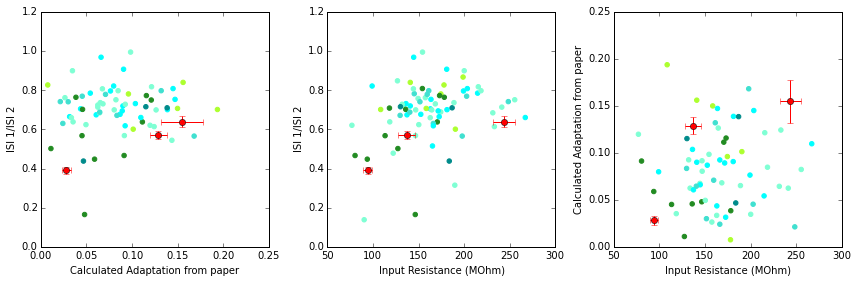

In [8]:
fig,axes = plt.subplots(1,3,figsize=(12,4))
axes[0].scatter(l5_brown.calc_adapt_index,l5_brown['iratio'],color = cell_color_listbr)
axes[0].errorbar([0.028,.129,.155],[.39,.57,.64],yerr = [.02,.02,.03], xerr = [.005,.009,.023], color = 'red', fmt = 'o')
axes[0].set_xlabel('Calculated Adaptation from paper')
axes[0].set_ylabel('ISI 1/ISI 2')
axes[0].set_xlim(0,.25)
axes[0].set_ylim(0,1.2)

axes[1].scatter(l5_brown.ri,l5_brown['iratio'],color = cell_color_listbr)
axes[1].errorbar([94.1,136.8,243.7],[.39,.57,.64],yerr = [0.02,0.02,0.03],xerr = [4.6,8.8,11.8],color = 'red',fmt = 'o')
axes[1].set_xlabel('Input Resistance (MOhm)')
axes[1].set_ylabel('ISI 1/ISI 2')
axes[1].set_ylim(0,1.2)
axes[1].set_xlim(50,300)

axes[2].scatter(l5_brown.ri,l5_brown.calc_adapt_index,color = cell_color_listbr)
axes[2].errorbar([94.1,136.8,243.7],[0.028,.129,.155],yerr = [.005,.009,.023], xerr = [4.6,8.8,11.8], color = 'red', fmt = 'o')
axes[2].set_ylabel('Calculated Adaptation from paper')
axes[2].set_xlabel('Input Resistance (MOhm)')
axes[2].set_ylim(0,.25)
axes[2].set_xlim(50,300)
plt.tight_layout()

# Three Types of Cortical Layer 5 Neurons That Differ in Brain-wide Connectivity and Function
###Kim et al 2015

###Their spike trains come from spiking frequency of 10-20 Hz. They used the slope of the linear regression line fitted to interspike time intervals (ISI), excluding the first four ISIs normalized to the fifth ISIs and plotted as a function of the ISI number (ISI #). In our method, we excluded the first four ISIs as some cells exhibited triplet initial bursts that did not reflect the steady state or "slow" adaptation seen after the fourth ISI. In order to compare our data with Groh et al. one must multiply by 100 as our results are not reported as a percentage. 

In [35]:
l5_kim = l5_df
l5_kim['ISI_initial/ISI_mean'] = None
l5_kim['paper_sweep'] = None
l5_kim['sag_amplitude'] = None
l5_kim['adaptation_index'] = None
for i, cell in enumerate(l5_kim['specimen_id']):
    rheo_sweep = l5_kim['rheobase_sweep_number'].iloc[i]
    data_set = ctc.get_ephys_data(cell)
    try:
        sweep_list = data_set.get_sweep_numbers()
        start = sweep_list.index(rheo_sweep)
        for s in range(start,len(sweep_list)):
            sweep_number = sweep_list[s]
            if data_set.get_sweep_metadata(sweep_number)['aibs_stimulus_name'] == 'Long Square':
                spike_train = data_set.get_spike_times(sweep_number)
                if len(spike_train) >= 10:
                    l5_kim['paper_sweep'].iloc[i] = sweep_number
                    initial_isi = spike_train[1]-spike_train[0]
                    isi = [spike_train[f] - spike_train[f-1] for f in range(1,len(spike_train))]
                    isi_ss = isi[4:]
                    l5_kim['ISI_initial/ISI_mean'].iloc[i] = initial_isi/np.mean(isi_ss)
                    A = np.vstack([isi_ss/isi_ss[0], np.ones_like(isi_ss)]).T
                    inv_slope,_ = np.linalg.lstsq(A,np.arange(0,len(isi_ss)))[0]
                    slope = 1/inv_slope
                    l5_kim['adaptation_index'].iloc[i] = slope/100
                   
                    break
        l5_kim['sag_amplitude'].iloc[i] = (l5_kim['vrest'].iloc[i] - l5_kim['vm_for_sag'].iloc[i])*l5_kim['sag'].iloc[i]
    except IOError:
        print cell

l5_kim = l5_kim[l5_kim['paper_sweep'].fillna('blank') != 'blank']


324053519


###Let's look at all the features from their paper

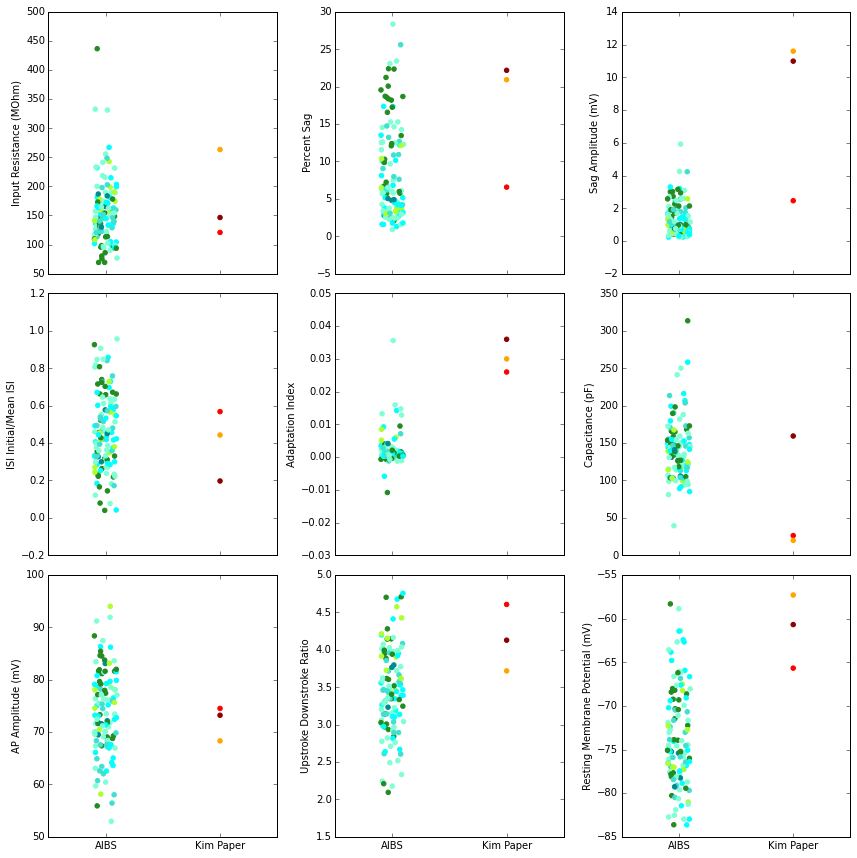

In [36]:
cell_color_listkm = [cell_color_dict[i] for i in l5_kim['cre_line']]
kim_color = ['red','darkred','orange']

#set up jitter on the AIBS dataset
x0=np.random.rand(len(l5_kim))*.2-.1

fig,axes = plt.subplots(3,3,figsize=(12,12), sharex=True)
axes[0,0].scatter(x0,l5_kim['ri'],color = cell_color_listkm)
axes[0,0].scatter(np.ones(3),[120.908,146.527,263.372], color = kim_color)
axes[0,0].set_xticks([0,1])
axes[0,0].set_xticklabels(['AIBS','Kim'])
axes[0,0].set_ylabel('Input Resistance (MOhm)')
axes[0,0].set_xlim(-.5,1.5)

axes[0,1].scatter(x0,l5_kim['sag']*100,color = cell_color_listkm)
axes[0,1].scatter(np.ones(3),[6.57,22.19,20.93], color = kim_color)
axes[0,1].set_xticks([0,1])
axes[0,1].set_xticklabels(['AIBS','Kim'])
axes[0,1].set_ylabel('Percent Sag')
axes[0,1].set_xlim(-.5,1.5)

axes[0,2].scatter(x0,l5_kim['sag_amplitude'],color = cell_color_listkm)
axes[0,2].scatter(np.ones(3),[2.46,10.99,11.60], color = kim_color)
axes[0,2].set_xticks([0,1])
axes[0,2].set_xticklabels(['AIBS','Kim'])
axes[0,2].set_ylabel('Sag Amplitude (mV)')
axes[0,2].set_xlim(-.5,1.5)

axes[1,0].scatter(x0,l5_kim['ISI_initial/ISI_mean'],color = cell_color_listkm)
axes[1,0].scatter(np.ones(3),[.568,.197,.443], color = kim_color)
axes[1,0].set_xticks([0,1])
axes[1,0].set_xticklabels(['AIBS','Kim'])
axes[1,0].set_ylabel('ISI Initial/Mean ISI')
axes[1,0].set_xlim(-.5,1.5)

axes[1,1].scatter(x0,l5_kim['adaptation_index'],color = cell_color_listkm)
axes[1,1].scatter(np.ones(3),[.026,.036,.03], color = kim_color)
axes[1,1].set_xticks([0,1])
axes[1,1].set_xticklabels(['AIBS','Kim'])
axes[1,1].set_ylabel('Adaptation Index')
axes[1,1].set_xlim(-.5,1.5)

axes[1,2].scatter(x0,l5_kim['tau']/l5_kim['ri']*1000,color = cell_color_listkm)
axes[1,2].scatter(np.ones(3),[26.30,159.4,19.77], color = kim_color)
axes[1,2].set_xticks([0,1])
axes[1,2].set_xticklabels(['AIBS','Kim'])
axes[1,2].set_ylabel('Capacitance (pF)')
axes[1,2].set_xlim(-.5,1.5)

axes[2,0].scatter(x0,l5_kim['peak_v_long_square']-l5_kim['threshold_v_long_square'],color = cell_color_listkm)
axes[2,0].scatter(np.ones(3),[74.52,73.22,68.32], color = kim_color)
axes[2,0].set_xticks([0,1])
axes[2,0].set_xticklabels(['AIBS','Kim Paper'])
axes[2,0].set_ylabel('AP Amplitude (mV)')
axes[2,0].set_xlim(-.5,1.5)

x_temp=[162.40/35.25,123.54/29.92,119.50/32.14]
axes[2,1].scatter(x0,l5_kim['upstroke_downstroke_ratio_long_square'],color = cell_color_listkm)
axes[2,1].scatter(np.ones(3),x_temp, color = kim_color)
axes[2,1].set_xticks([])
axes[2,1].set_xticklabels(['AIBS','Kim Paper'])
axes[2,1].set_ylabel('Upstroke Downstroke Ratio')
axes[2,1].set_xlim(-.5,1.5)

axes[2,2].scatter(x0,l5_kim['vrest'],color = cell_color_listkm)
axes[2,2].scatter(np.ones(3),[-65.67,-60.68,-57.29], color = kim_color)
axes[2,2].set_xticks([0,1])
axes[2,2].set_xticklabels(['AIBS','Kim Paper'])
axes[2,2].set_ylabel('Resting Membrane Potential (mV)')
axes[2,2].set_xlim(-.5,1.5)

plt.tight_layout()

###And now let's compare a few features

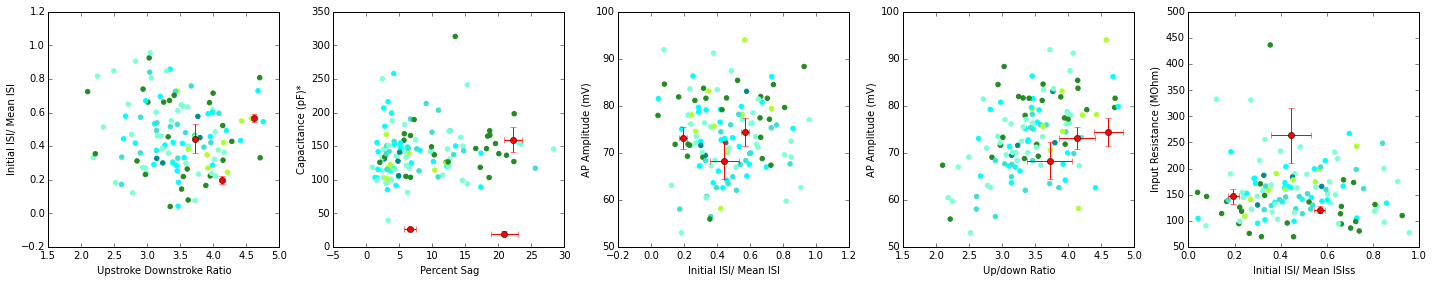

In [39]:
cell_color_listkm = [cell_color_dict[i] for i in l5_kim['cre_line']]
fig,axes = plt.subplots(1,5,figsize=(20,4))

axes[0].scatter(l5_kim['upstroke_downstroke_ratio_long_square'],l5_kim['ISI_initial/ISI_mean'], color = cell_color_listkm)
axes[0].errorbar([4.61,4.13,3.72],[.568,.197,.443], yerr = [.024,.024,.086], color = 'red', fmt = 'o')
#plt.annotate('Tlx3',xy=(.568,120.908))
axes[0].set_xlabel('Upstroke Downstroke Ratio')
axes[0].set_ylabel('Initial ISI/ Mean ISI')
#axes[0].set_xlim(0,1)
#axes[0].set_ylim(50,400)

axes[1].scatter(l5_kim['sag']*100,l5_kim['tau']/l5_kim['ri']*1000, color = cell_color_listkm)
axes[1].errorbar([6.57,22.19,20.93],[26.30,159.4,19.77],xerr = [.88,1.34,2.05], yerr = [1.907,18.49,3.348], color = 'red', fmt = 'o')
axes[1].set_xlabel('Percent Sag')
axes[1].set_ylabel('Capacitance (pF)*')

axes[2].scatter(l5_kim['ISI_initial/ISI_mean'],l5_kim['peak_v_long_square']-l5_kim['threshold_v_long_square'],color = cell_color_listkm)
axes[2].errorbar([.568,.194,.443],[74.52,73.22,68.32],xerr = [0.024,0.024,0.086], yerr = [2.96,2.32,3.89], color = 'red', fmt = 'o')
axes[2].set_xlabel('Initial ISI/ Mean ISI')
axes[2].set_ylabel('AP Amplitude (mV)')

axes[3].scatter(l5_kim['upstroke_downstroke_ratio_long_square'],l5_kim['peak_v_long_square']-l5_kim['threshold_v_long_square'],color = cell_color_listkm)
x_temp=[162.40/35.25,123.54/29.92,119.50/32.14]
xerr=[3.1/14.35,2.28/8.46,6.57/19.24]
axes[3].errorbar(x_temp,[74.52,73.22,68.32],xerr = xerr, yerr = [2.96,2.32,3.89], color = 'red', fmt = 'o')
axes[3].set_xlabel('Up/down Ratio')
axes[3].set_ylabel('AP Amplitude (mV)')

axes[4].scatter(l5_kim['ISI_initial/ISI_mean'],l5_kim['ri'], color = cell_color_listkm)
axes[4].errorbar([.568,.194,.443],[120.908,146.365,263.372],xerr = [0.024,0.024,0.086], yerr = [6.678,14.527,52.722], color = 'red', fmt = 'o')
axes[4].set_xlabel('Initial ISI/ Mean ISIss')
axes[4].set_ylabel('Input Resistance (MOhm)')
axes[4].set_xlim(0,1)
#axes[4].set_ylim(50,400)

plt.tight_layout()

# Feature Identification

Brown index for 485834744: 0.0513051987332
Kim index for 485834744: 0.0531318151566

Brown index for 466431949: 0.131733006334
Kim index for 466431949: 0.179042282801



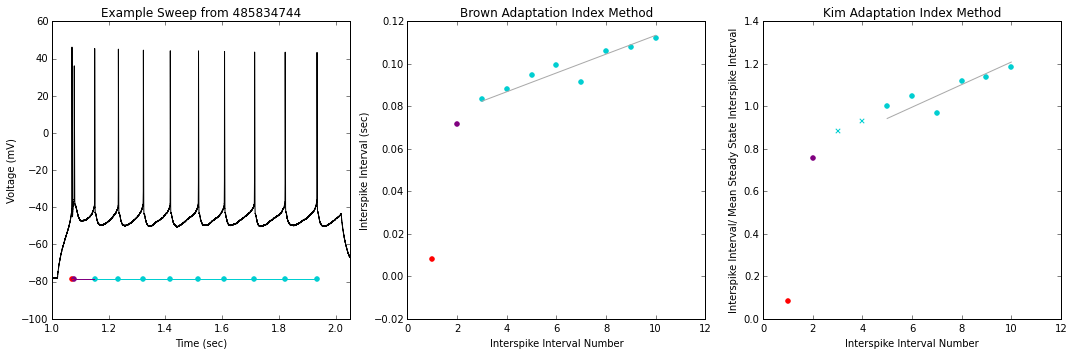

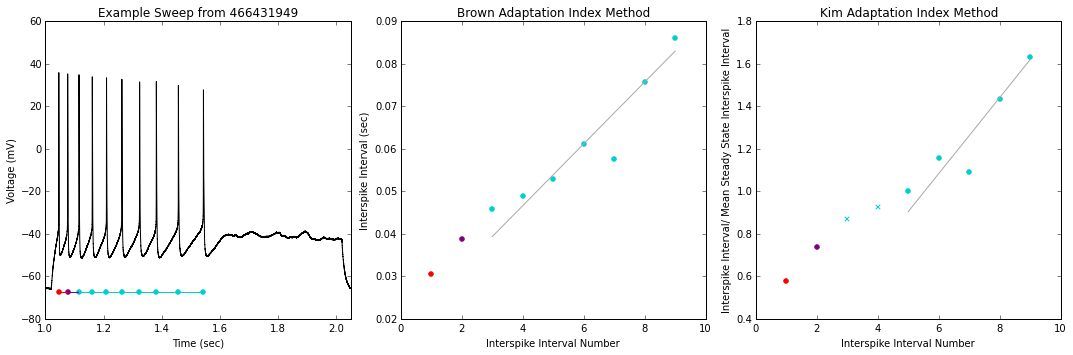

In [44]:
for cell in range(2):
    data_set = ctc.get_ephys_data(l5_kim['specimen_id'].iloc[cell])
    sweep_data = data_set.get_sweep(l5_kim['paper_sweep'].iloc[cell])
    spike_train = data_set.get_spike_times(l5_kim['paper_sweep'].iloc[cell])

    index_range = sweep_data["index_range"]
    i = sweep_data["stimulus"][0:index_range[1]+1] # in A
    v = sweep_data["response"][0:index_range[1]+1] # in V
    i *= 1e12 # to pA
    v *= 1e3 # to mV

    sampling_rate = sweep_data["sampling_rate"] # in Hz
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)

    fig,axes = plt.subplots(1,3,figsize = (15,5))

    axes[0].plot(t,v,color = 'black')
    axes[0].scatter(spike_train[0], v.min(), color = 'red')
    axes[0].plot(spike_train[:2],[v.min(),v.min()],color = 'red')
    axes[0].scatter(spike_train[1], v.min(), color = 'purple')
    axes[0].plot(spike_train[1:3],[v.min(),v.min()],color = 'purple')
    axes[0].scatter(spike_train[2:], np.ones(len(spike_train[2:]))*v.min(), color = 'darkturquoise')
    axes[0].plot(spike_train[2:],np.ones(len(spike_train[2:]))*v.min(),color = 'darkturquoise')
    axes[0].set_xlim(1,2.05)
    axes[0].set_xlabel('Time (sec)')
    axes[0].set_ylabel('Voltage (mV)')
    title = 'Example Sweep from %s' %str(l5_kim['specimen_id'].iloc[cell])
    axes[0].set_title(title)

    isi = [spike_train[f]-spike_train[f-1] for f in range(1,len(spike_train))]
    #find steady state ISIs
    isi_ss = isi[2:]
    #get slope of steady state ISIs
    A = np.vstack([isi_ss, np.ones_like(isi_ss)]).T
    inv_slope,c = np.linalg.lstsq(A,np.arange(0,len(isi_ss)))[0]

    slope = 1/inv_slope
    print 'Brown index for %s: '%str(l5_kim['specimen_id'].iloc[cell]) + str(slope/np.mean(isi))

    axes[1].scatter(1,isi[0], color = 'red')
    axes[1].scatter(2,isi[1], color = 'purple')
    axes[1].scatter(np.arange(len(isi_ss))+3,isi_ss, color = 'darkturquoise')
    axes[1].plot(np.arange(len(isi_ss))+3,np.arange(len(isi_ss))*slope -c*slope, color = 'darkgrey')
    axes[1].set_xlabel('Interspike Interval Number')
    axes[1].set_ylabel('Interspike Interval (sec)')
    axes[1].set_title('Brown Adaptation Index Method')

    isi_ss = isi[4:]
    mean_isi = np.mean(isi_ss)
    A = np.vstack([isi_ss/isi_ss[0], np.ones_like(isi_ss)]).T
    inv_slope,c = np.linalg.lstsq(A,np.arange(0,len(isi_ss)))[0]

    slope = 1/inv_slope
    print 'Kim index for %s: ' %str(l5_kim['specimen_id'].iloc[cell])+ str(slope)
    print ""

    axes[2].scatter(1,isi[0]/isi_ss[0], color = 'red')
    axes[2].scatter(2,isi[1]/isi_ss[0], color = 'purple')
    axes[2].scatter([3,4],isi[2:4]/isi_ss[0], color = 'darkturquoise',marker = 'x')
    axes[2].scatter(np.arange(len(isi_ss))+5,isi_ss/isi_ss[0], color = 'darkturquoise')
    axes[2].plot(np.arange(len(isi_ss))+5,np.arange(len(isi_ss))*slope -c*slope, color = 'darkgrey')
    axes[2].set_xlabel('Interspike Interval Number')
    axes[2].set_ylabel('Interspike Interval/ Mean Steady State Interspike Interval')
    axes[2].set_title('Kim Adaptation Index Method')


    plt.tight_layout()

# Let's Look at all the Connectivity of V1

In [60]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')
all_experiments = mcc.get_experiments(dataframe=True)

###This will give all injections into V1 including secondary injection sites so there will be some error with this

In [61]:
ontology = mcc.get_ontology()

isocortex = ontology['Isocortex']
vis = ontology['VIS']

visl5_cre_experiments = mcc.get_experiments(cre=['Rbp4-Cre_KL100','Scnn1a-Tg3-Cre',
                                                 'Rorb-IRES2-Cre','Tlx3-Cre_PL56',
                                                 'Glt25d2-Cre_NF107','Efr3a-Cre_No108'], 
                                                injection_structure_ids=vis['id'])

print "%d VIS Layer 5, Cre+ experiments" % len(visl5_cre_experiments)

46 VIS Cre+ L5 experiments


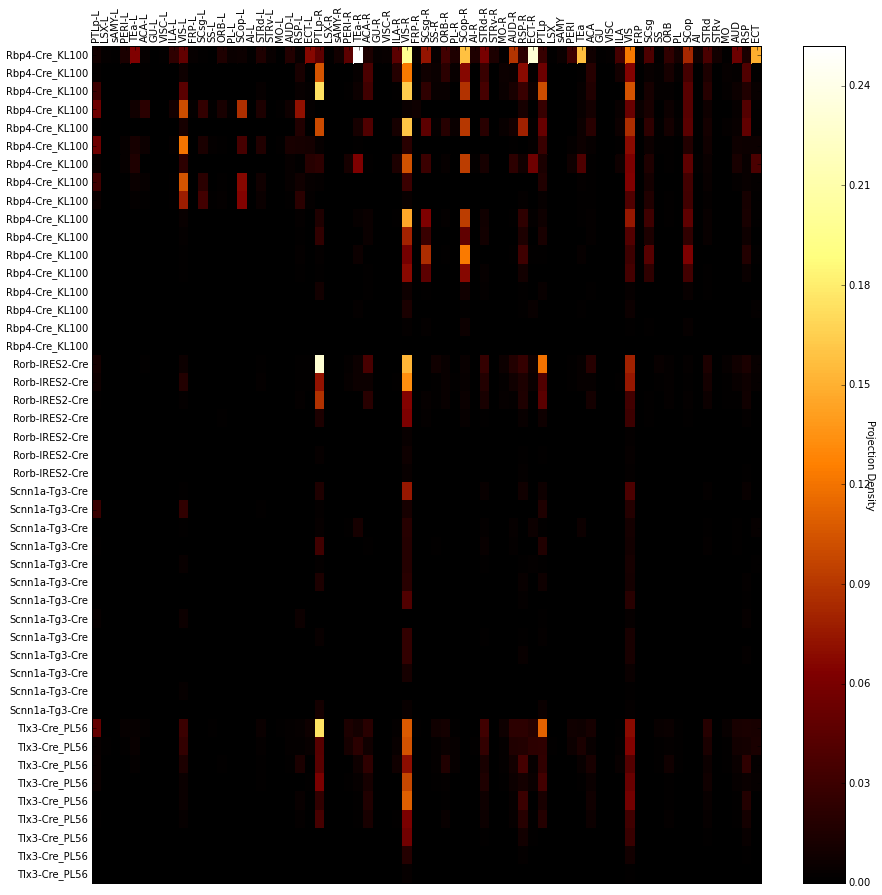

In [62]:
visl5_sorted = sorted(visl5_cre_experiments, key=lambda k: k['transgenic-line'])
vis_experiment_ids = [ e['id'] for e in visl5_sorted ]
ctx_children = ontology.get_child_ids([ontology['STR'].id,ontology['SCs'].id,ontology['Isocortex'].id])

pm = mcc.get_projection_matrix(experiment_ids = vis_experiment_ids, 
                               projection_structure_ids = ctx_children,
                               #hemisphere_ids= [], # right hemisphere, ipsilateral
                               parameter = 'projection_density')

row_labels = [f['transgenic-line'] for f in visl5_sorted]
#row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(15,15))
heatmap = ax.pcolor(matrix, cmap=plt.cm.afmhot)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False,rotation = 90)
ax.set_yticklabels(row_labels, minor=False)

cbar = plt.colorbar(heatmap)
cbar.set_label('Projection Density', rotation = 270)

plt.show()

In [46]:
morphology_features = ctc.get_morphology_features()

In [81]:
cell_id = 479721491
morphology = ctc.get_reconstruction(cell_id) 
radius_test = 0
# the compartment list has all of the nodes in the file
for i in morphology.compartment_list[0]['children']:
    if morphology.compartment_list[i]['type'] == 4:
        radius = morphology.compartment_list[i]['radius']

In [2]:
sorted(morphology_features[0].keys())
morphology_features[0]['average_diameter']

NameError: name 'morphology_features' is not defined

In [82]:
print morphology_features[0]['soma_surface']
print morphology_features[0]['overall_height']/morphology_features[0]['overall_width']
print radius

437.744827421
4.11036808699
0.5906
0
{'parent': 2192, 'children': [2194, 2349], 'radius': 0.8613, 'tree_id': 0, 'y': 388.6477, 'x': 318.0286, 'z': 46.7746, 'type': 4, 'id': 2193}


In [77]:
morphology.compartment_list[0]

{'children': [1, 81, 168, 581, 669, 956, 1090, 1391, 1799, 2143],
 'id': 0,
 'parent': -1,
 'radius': 6.1212,
 'tree_id': 0,
 'type': 1,
 'x': 331.3024,
 'y': 403.3744,
 'z': 44.24}

In [53]:
help(ctc.get_morphology_features())

Help on list object:

class list(object)
 |  list() -> new empty list
 |  list(iterable) -> new list initialized from iterable's items
 |  
 |  Methods defined here:
 |  
 |  __add__(...)
 |      x.__add__(y) <==> x+y
 |  
 |  __contains__(...)
 |      x.__contains__(y) <==> y in x
 |  
 |  __delitem__(...)
 |      x.__delitem__(y) <==> del x[y]
 |  
 |  __delslice__(...)
 |      x.__delslice__(i, j) <==> del x[i:j]
 |      
 |      Use of negative indices is not supported.
 |  
 |  __eq__(...)
 |      x.__eq__(y) <==> x==y
 |  
 |  __ge__(...)
 |      x.__ge__(y) <==> x>=y
 |  
 |  __getattribute__(...)
 |      x.__getattribute__('name') <==> x.name
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __getslice__(...)
 |      x.__getslice__(i, j) <==> x[i:j]
 |      
 |      Use of negative indices is not supported.
 |  
 |  __gt__(...)
 |      x.__gt__(y) <==> x>y
 |  
 |  __iadd__(...)
 |      x.__iadd__(y) <==> x+=y
 |  
 |  __imul__(...)
 |      x.__imul__(y) <==